# Imports

In [1]:
import os
from typing import List
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging 

logging.basicConfig(
     level=logging.INFO, 
     format= '[%(asctime)s|%(levelname)s|%(module)s.py:%(lineno)s] %(message)s',
     datefmt='%H:%M:%S'
 )
import tqdm.notebook as tq
from tqdm import tqdm
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold

import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding

from defi_textmine_2025.data.utils import TARGET_COL, INTERIM_DIR, EDA_DIR

[00:51:09|INFO|config.py:58] PyTorch version 2.3.1 available.
[00:51:09|INFO|config.py:105] TensorFlow version 2.16.2 available.
2024-10-11 00:51:10.575859: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 00:51:10.583753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 00:51:10.595661: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 00:51:10.595682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register fact

# Constants

In [18]:
RANDOM_SEED = 0  # random reproducibility
logging.info(f"{RANDOM_SEED=}")
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

STEP1_TASK_TARGET_COL = "hasrelation_label"
logging.info(f"{STEP1_TASK_TARGET_COL=}")
STEP2_TASK_TARGET_COL = "whatrelation_label"
logging.info(f"{STEP2_TASK_TARGET_COL=}")
TASK_INPUT_COL = "input_text"

entity_classes = {'TERRORIST_OR_CRIMINAL', 'LASTNAME', 'LENGTH', 'NATURAL_CAUSES_DEATH', 'COLOR', 'STRIKE', 'DRUG_OPERATION', 'HEIGHT', 'INTERGOVERNMENTAL_ORGANISATION', 'TRAFFICKING', 'NON_MILITARY_GOVERNMENT_ORGANISATION', 'TIME_MIN', 'DEMONSTRATION', 'TIME_EXACT', 'FIRE', 'QUANTITY_MIN', 'MATERIEL', 'GATHERING', 'PLACE', 'CRIMINAL_ARREST', 'CBRN_EVENT', 'ECONOMICAL_CRISIS', 'ACCIDENT', 'LONGITUDE', 'BOMBING', 'MATERIAL_REFERENCE', 'WIDTH', 'FIRSTNAME', 'MILITARY_ORGANISATION', 'CIVILIAN', 'QUANTITY_MAX', 'CATEGORY', 'POLITICAL_VIOLENCE', 'EPIDEMIC', 'TIME_MAX', 'TIME_FUZZY', 'NATURAL_EVENT', 'SUICIDE', 'CIVIL_WAR_OUTBREAK', 'POLLUTION', 'ILLEGAL_CIVIL_DEMONSTRATION', 'NATIONALITY', 'GROUP_OF_INDIVIDUALS', 'QUANTITY_FUZZY', 'RIOT', 'WEIGHT', 'THEFT', 'MILITARY', 'NON_GOVERNMENTAL_ORGANISATION', 'LATITUDE', 'COUP_D_ETAT', 'ELECTION', 'HOOLIGANISM_TROUBLEMAKING', 'QUANTITY_EXACT', 'AGITATING_TROUBLE_MAKING'}
categories_to_check = ['END_DATE', 'GENDER_MALE', 'WEIGHS', 'DIED_IN', 'HAS_FAMILY_RELATIONSHIP', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'HAS_CATEGORY', 'HAS_CONTROL_OVER', 'IS_BORN_IN', 'IS_OF_SIZE', 'HAS_LATITUDE', 'IS_PART_OF', 'IS_OF_NATIONALITY', 'IS_COOPERATING_WITH', 'DEATHS_NUMBER', 'HAS_FOR_HEIGHT', 'INITIATED', 'WAS_DISSOLVED_IN', 'HAS_COLOR', 'CREATED', 'IS_LOCATED_IN', 'WAS_CREATED_IN', 'IS_AT_ODDS_WITH', 'HAS_CONSEQUENCE', 'HAS_FOR_LENGTH', 'INJURED_NUMBER', 'START_DATE', 'STARTED_IN', 'GENDER_FEMALE', 'HAS_LONGITUDE', 'RESIDES_IN', 'HAS_FOR_WIDTH', 'IS_BORN_ON', 'HAS_QUANTITY', 'OPERATES_IN', 'IS_REGISTERED_AS']

onehot_label_encoder = MultiLabelBinarizer()
onehot_label_encoder.fit([categories_to_check])
ONE_HOT_TARGET_COLS = onehot_label_encoder.classes_.tolist()
logging.info(f"{ONE_HOT_TARGET_COLS=}")


generated_data_dir_path = os.path.join(INTERIM_DIR, "reduced_text_w_entity_bracket")
assert os.path.exists(generated_data_dir_path)
train_dir = os.path.join(generated_data_dir_path, "train")
test_dir = os.path.join(generated_data_dir_path, "test")

preprocessed_data_dir = os.path.join(INTERIM_DIR, "one_hot_reduced_text_w_entity_bracket")
labeled_preprocessed_data_dir_path = os.path.join(preprocessed_data_dir,"train")
! mkdir -p {labeled_preprocessed_data_dir_path}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
logging.info(f"{device=}")

[00:58:42|INFO|3630015589.py:2] RANDOM_SEED=0
[00:58:42|INFO|3630015589.py:7] STEP1_TASK_TARGET_COL='hasrelation_label'
[00:58:42|INFO|3630015589.py:9] STEP2_TASK_TARGET_COL='whatrelation_label'
[00:58:42|INFO|3630015589.py:18] ONE_HOT_TARGET_COLS=['CREATED', 'DEATHS_NUMBER', 'DIED_IN', 'END_DATE', 'GENDER_FEMALE', 'GENDER_MALE', 'HAS_CATEGORY', 'HAS_COLOR', 'HAS_CONSEQUENCE', 'HAS_CONTROL_OVER', 'HAS_FAMILY_RELATIONSHIP', 'HAS_FOR_HEIGHT', 'HAS_FOR_LENGTH', 'HAS_FOR_WIDTH', 'HAS_LATITUDE', 'HAS_LONGITUDE', 'HAS_QUANTITY', 'INITIATED', 'INJURED_NUMBER', 'IS_AT_ODDS_WITH', 'IS_BORN_IN', 'IS_BORN_ON', 'IS_COOPERATING_WITH', 'IS_DEAD_ON', 'IS_IN_CONTACT_WITH', 'IS_LOCATED_IN', 'IS_OF_NATIONALITY', 'IS_OF_SIZE', 'IS_PART_OF', 'IS_REGISTERED_AS', 'OPERATES_IN', 'RESIDES_IN', 'STARTED_IN', 'START_DATE', 'WAS_CREATED_IN', 'WAS_DISSOLVED_IN', 'WEIGHS']
[00:58:42|INFO|3630015589.py:31] device=device(type='cuda')


In [3]:
def get_cat_var_distribution(cat_var: pd.Series | pd.DataFrame) -> pd.DataFrame:
    if isinstance(cat_var, pd.Series):
        return pd.concat([cat_var.value_counts(), cat_var.value_counts(normalize=True)], axis=1)
    else:
        return pd.concat([cat_var.sum(axis=0).rename("count"), (cat_var.sum(axis=0)/cat_var.shape[0]).rename("proportion")], axis=1)
        

# Load the data

In [4]:
def load_csv(dir_or_file_path: str, index_col=None, sep=',') -> pd.DataFrame:
    if os.path.isdir(dir_or_file_path):
        all_files = glob.glob(os.path.join(dir_or_file_path , "*.csv"))  
    else:
        assert dir_or_file_path.endswith(".csv")
        all_files = [dir_or_file_path]
    assert len(all_files) > 0
    return pd.concat([pd.read_csv(filename, index_col=index_col, header=0, sep=sep) for filename in all_files], axis=0, ignore_index=True)

In [5]:
labeled_df = load_csv(train_dir, index_col=0)
logging.info(f"{labeled_df.shape=}")
labeled_df.head(2)

[00:51:14|INFO|4131575051.py:2] labeled_df.shape=(122044, 8)


,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ..."
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ..."


In [6]:
test_df = load_csv(test_dir, index_col=0)
logging.info(f"{test_df.shape=}")
test_df.head(2)

[00:51:15|INFO|648572524.py:2] test_df.shape=(53002, 8)


,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text
0,51344,0,1,FIRE,PLACE,Un { incendie } a eu lieu hier matin au [ Port...,NaN,Un { incendie } a eu lieu hier matin au [ Port...
1,51344,1,1,PLACE,PLACE,Un incendie a eu lieu hier matin au < Portugal...,NaN,Un incendie a eu lieu hier matin au < Portugal >.


# Process the input and target

In [7]:
def format_relations_str_to_list(labels_as_str: str) -> List[str]:
    return json.loads(
        labels_as_str.replace("{", "[").replace("}", "]").replace("'", '"')
    )  if pd.notnull(labels_as_str) else []

def encode_target_to_onehot(data: pd.DataFrame) -> pd.DataFrame:
    data[ONE_HOT_TARGET_COLS] = pd.DataFrame(onehot_label_encoder.transform(data[TARGET_COL].apply(format_relations_str_to_list)), columns=onehot_label_encoder.classes_, index=data.index).astype(float)
    return data

In [8]:
labeled_df = encode_target_to_onehot(
    labeled_df.assign(**{
        TASK_INPUT_COL: lambda df: df["reduced_text"],
        STEP1_TASK_TARGET_COL: lambda df: pd.notnull(df.relations).astype(int),
    })
)
logging.info(f"{labeled_df.shape=}")
labeled_df.head(2)

[00:51:16|INFO|1549835487.py:7] labeled_df.shape=(122044, 47)


,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text,input_text,hasrelation_label,...,IS_OF_SIZE,IS_PART_OF,IS_REGISTERED_AS,OPERATES_IN,RESIDES_IN,STARTED_IN,START_DATE,WAS_CREATED_IN,WAS_DISSOLVED_IN,WEIGHS
0,2576,1,0,FIRE,GATHERING,"Le matin du 10 janvier 2010, Arthur et Jacques...",NaN,"Au milieu de l’[ interview ], un { incendie } ...","Au milieu de l’[ interview ], un { incendie } ...",0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2576,0,1,GATHERING,FIRE,"Le matin du 10 janvier 2010, Arthur et Jacques...",['HAS_CONSEQUENCE'],"Au milieu de l’{ interview }, un [ incendie ] ...","Au milieu de l’{ interview }, un [ incendie ] ...",1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
test_df = test_df.assign(**{
        TASK_INPUT_COL: lambda df: df["reduced_text"],
    })
logging.info(f"{test_df.shape=}")
test_df.head(2)

[00:51:16|INFO|3560078201.py:4] test_df.shape=(53002, 9)


,text_index,e1_id,e2_id,e1_type,e2_type,text,relations,reduced_text,input_text
0,51344,0,1,FIRE,PLACE,Un { incendie } a eu lieu hier matin au [ Port...,NaN,Un { incendie } a eu lieu hier matin au [ Port...,Un { incendie } a eu lieu hier matin au [ Port...
1,51344,1,1,PLACE,PLACE,Un incendie a eu lieu hier matin au < Portugal...,NaN,Un incendie a eu lieu hier matin au < Portugal >.,Un incendie a eu lieu hier matin au < Portugal >.


In [10]:
test_df.iloc[1].reduced_text

'Un incendie a eu lieu hier matin au < Portugal >.'

In [11]:
labeled_df.to_parquet(os.path.join(INTERIM_DIR, "train-preprocessed_for_mth2.parquet"), index=False)
test_df.to_parquet(os.path.join(INTERIM_DIR, "test-preprocessed_for_mth2.parquet"), index=False)

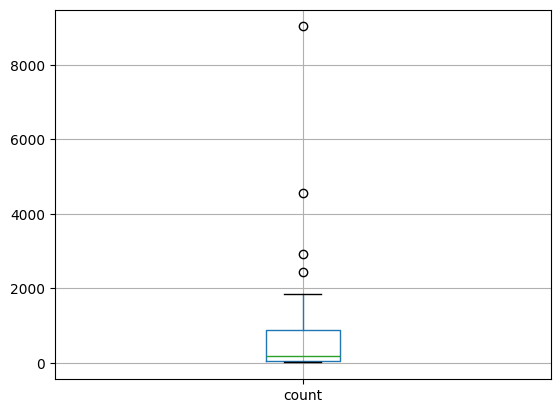

In [12]:
get_cat_var_distribution(labeled_df[ONE_HOT_TARGET_COLS]).boxplot(column=["count"])
plt.show()

# 5-fold cross-validation split

In [20]:
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)
k = 1
for train_index, val_index in kf.split(labeled_df, groups=labeled_df[TARGET_COL]):
    train_df, val_df = labeled_df.loc[train_index], labeled_df.loc[val_index]
    train_df.to_parquet(f"{INTERIM_DIR}/train-fold{k}-mth2.parquet")
    val_df.to_parquet(f"{INTERIM_DIR}/validation-fold{k}-mth2.parquet")
    print("fold", k, train_index, val_index, train_df.shape, val_df.shape)
    get_cat_var_distribution(val_df[ONE_HOT_TARGET_COLS]).sort_values(by="count").to_csv(f"{EDA_DIR}/validation-fold{k}_relation_distrib-{RANDOM_SEED=}-mth2.csv")
    k += 1


fold 1 [     0      1      2 ... 122040 122041 122042] [     3      6     12 ... 122035 122036 122043] (97635, 47) (24409, 47)
fold 2 [     0      1      2 ... 122040 122041 122043] [     8      9     11 ... 122037 122039 122042] (97635, 47) (24409, 47)
fold 3 [     2      3      6 ... 122041 122042 122043] [     0      1      4 ... 122032 122034 122038] (97635, 47) (24409, 47)
fold 4 [     0      1      2 ... 122039 122042 122043] [     7     16     19 ... 122033 122040 122041] (97635, 47) (24409, 47)
fold 5 [     0      1      3 ... 122041 122042 122043] [     2     10     13 ... 122016 122019 122021] (97636, 47) (24408, 47)


# Create the tokenized datasets for model input

## init the tokenizer

In [21]:
# Hyperparameters
BASE_CHECKPOINT = "camembert/camembert-base"
tokenizer = AutoTokenizer.from_pretrained(BASE_CHECKPOINT)
# task_special_tokens = ["<", ">", "{", "}", "[", "]"]
# # add special tokens to the tokenizer
# num_added_tokens = tokenizer.add_tokens(task_special_tokens, special_tokens=True)
# num_added_tokens, len(tokenizer)

/home/tagny/.pyenv/versions/3.11.8/envs/kgl11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## init the train-valid datasets from dataframe

In [22]:
def process_label(ds: Dataset) -> Dataset:
    """Replace target label columns by a single list label column """
    return ds.map(lambda example: {STEP2_TASK_TARGET_COL: [example[_class] for _class in ONE_HOT_TARGET_COLS]}).remove_columns(ONE_HOT_TARGET_COLS)

train_ds = process_label(Dataset.from_pandas(train_df, preserve_index=False)).shuffle(seed=RANDOM_SEED)
val_ds = process_label(Dataset.from_pandas(val_df, preserve_index=False))
task_datasets = DatasetDict({"train": train_ds, "validation": val_ds})
task_datasets

Map:   0%|          | 0/97636 [00:00<?, ? examples/s]

Map:   0%|          | 0/24408 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label'],
        num_rows: 97636
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label'],
        num_rows: 24408
    })
})

In [23]:
print(task_datasets["train"][1][STEP2_TASK_TARGET_COL])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
print(task_datasets["train"][1])

{'text_index': 3785, 'e1_id': 7, 'e2_id': 20, 'e1_type': 'MATERIEL', 'e2_type': 'TIME_EXACT', 'text': 'Le vendredi 5 août 2022, Monsieur Tellier Mahaut, le président de l\'association "Fever Summer", a officiellement ouvert le festival de la musique de Cancun. L\'événement a eu lieu au stade Andres Quintana Roo. Une tombola avait été organisée pour permettre aux participants de remporter des lots. Parmi les gros lots, il y avait des billets pour une croisière sur un paquebot ou encore un tour en { hélicoptère } au-dessus de Cancun. D\'autres lots étaient composés de tablettes et de smartphones. Il y avait même 3 500 pesos à remporter. L\'événement a duré [ trois jours ] et s\'est terminé par le concert des Thunderhead.', 'relations': None, 'reduced_text': "Parmi les gros lots, il y avait des billets pour une croisière sur un paquebot ou encore un tour en { hélicoptère } au-dessus de Cancun. L'événement a duré [ trois jours ] et s'est terminé par le concert des Thunderhead.", 'input_tex

## Tokenize the datasets

In [25]:
def tokenize_function(example: dict):
    return tokenizer(example[TASK_INPUT_COL], truncation=True)

# We’re using batched=True in our call to map so the function is applied to multiple elements of our dataset at once, and not on each element separately
# This is way faster
# Source https://huggingface.co/learn/nlp-course/chapter3/2?fw=pt
# columns are removed because DataCollatorWithPadding doesn't support any other columns than the ones produced by the tokenizer (or non tensors)
tokenized_datasets = task_datasets.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/97636 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/24408 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label', 'input_ids', 'attention_mask'],
        num_rows: 97636
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label', 'input_ids', 'attention_mask'],
        num_rows: 24408
    })
})

In [26]:
print(tokenized_datasets.column_names)

{'train': ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label', 'input_ids', 'attention_mask'], 'validation': ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label', 'input_ids', 'attention_mask']}


In [27]:
type(tokenized_datasets["train"][1]['attention_mask'])

list

## Token numbers distribution

In [28]:
from typing import Any, Dict

def count_tokens(text: str) -> int:
    return len(tokenizer(text)["input_ids"])


def count_token_in_dataset_element(example: Dict[str, Any]) -> Dict[str, int]:
    return {"n_tokens": count_tokens(example[TASK_INPUT_COL])}


tokenized_datasets = tokenized_datasets.map(count_token_in_dataset_element)
tokenized_datasets

Map:   0%|          | 0/97636 [00:00<?, ? examples/s]

Map:   0%|          | 0/24408 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 97636
    })
    validation: Dataset({
        features: ['text_index', 'e1_id', 'e2_id', 'e1_type', 'e2_type', 'text', 'relations', 'reduced_text', 'input_text', 'hasrelation_label', 'whatrelation_label', 'input_ids', 'attention_mask', 'n_tokens'],
        num_rows: 24408
    })
})

In [29]:
split2ntokens_df = pd.DataFrame(
    {
        split_name: pd.Series(
            [e["n_tokens"] for e in tqdm(tokenized_datasets[split_name], split_name)],
            name=f"{split_name}_text_n_tokens",
        )
        for split_name in tokenized_datasets.keys()
    }
)
split2ntokens_df.describe()

validation: 100%|██████████| 24408/24408 [00:02<00:00, 10777.81it/s]


,train,validation
count,97636.000000,24408.000000
mean,65.425048,65.366191
std,30.009595,30.354460
min,10.000000,11.000000
25%,44.000000,44.000000
50%,60.000000,60.000000
75%,80.000000,80.000000
max,303.000000,278.000000


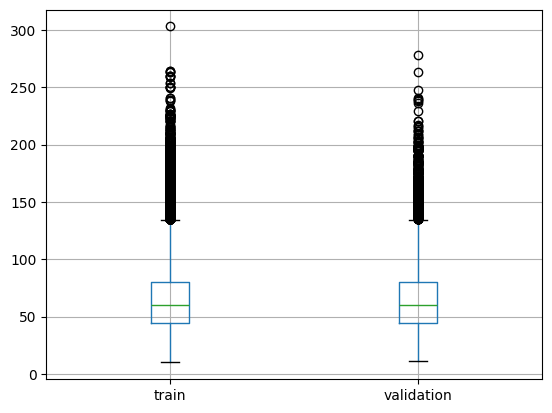

In [30]:
split2ntokens_df.boxplot()
plt.show()

In [31]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == split2ntokens_df.train.max()).select_columns([TARGET_COL, TASK_INPUT_COL])[0]

Filter:   0%|          | 0/97636 [00:00<?, ? examples/s]

{'relations': "['IS_LOCATED_IN']",
 'input_text': "Le 23 mai 2017, l'association protégeant les droits des enfants a décidé de construire un [ terrain de basket ] pour les jeunes de Marrakech. Cependant, deux ans après la construction du [ terrain ], les habitants ont commencé à avoir des différends concernant sa gestion. Le maire de la ville, Monsieur Kireg Mohamed, a expliqué que les habitants du quartier Est, zone où se trouve le [ terrain ], ne laissaient pas les habitants du quartier Ouest [ l' ]utiliser. D'après certains jeunes du quartier Est, cette opposition est due au fait que ceux du quartier Ouest salissent le [ terrain ] et n'utilisent pas les poubelles disposées dans la zone. Jeudi dernier, l'inévitable s'est produit et a entraîné l'envoi à l'hôpital d'{ Hassan Mohamed }, le { fils } du maire. D'après des sources anonymes, des jeunes du quartier Ouest sont entrés sur le [ terrain ] sans l'accord du gardien. Ce dernier a prévenu des gens qui se trouvaient là, qui ont comme

In [32]:
tokenized_datasets["train"].filter(lambda x: x['n_tokens'] == split2ntokens_df.train.min()).select_columns([TARGET_COL, TASK_INPUT_COL])[0]

Filter:   0%|          | 0/97636 [00:00<?, ? examples/s]

{'relations': None, 'input_text': 'Les < commerçants > sont désespérés.'}

In [33]:
tokenized_datasets["train"].take(10)[:]["n_tokens"]

[56, 57, 32, 36, 107, 42, 83, 47, 40, 72]

In [34]:
tokenized_datasets["train"].take(10).sort("n_tokens")["n_tokens"]

[32, 36, 40, 42, 47, 56, 57, 72, 83, 107]

## Sort examples by text size to accelerate the training and inference

In [41]:
tokenized_datasets["validation"].take(10)["n_tokens"]

[32, 39, 39, 39, 39, 67, 67, 82, 63, 68]

In [42]:
tokenized_datasets = tokenized_datasets.sort("n_tokens")

In [43]:
tokenized_datasets["validation"].take(10)["n_tokens"]

[11, 11, 12, 12, 13, 13, 13, 13, 13, 13]

## Test the batch-level padding with a data collator

In [38]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [39]:
samples = tokenized_datasets.remove_columns(task_datasets["train"].column_names)["train"][:8]
samples = {k: v for k, v in samples.items()}
[len(x) for x in samples["input_ids"]]

[56, 57, 32, 36, 107, 42, 83, 47]

In [40]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 107]),
 'attention_mask': torch.Size([8, 107]),
 'n_tokens': torch.Size([8])}